
# Name : **Shravanthi Balasubramanian**
# School :SCDS
# Email ID : *shravanthi.b-26@scds.saiuniversity.edu.in

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Dropout, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import shutil
import zipfile
import os


zip_path = '/content/drive/MyDrive/Car_Dataset.zip'
extract_path = '/content/Car_Dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted to:", extract_path)

#define directories
source_dir = '/content/Car_Dataset/Car_Dataset'
train_dir = '/content/splits/train'
test_dir = '/content/splits/test'

if os.path.exists(source_dir):
    print("Source directory exists:", os.listdir(source_dir))
else:
    print("Source directory does not exist:", source_dir)

print("Train directory exists:", os.path.exists(train_dir))
print("Test directory exists:", os.path.exists(test_dir))

for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    if os.path.isdir(class_path):
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        all_files = os.listdir(class_path)
        train_files, test_files = train_test_split(all_files, test_size=0.25, random_state=42)

        for file in train_files:
            src = os.path.join(class_path, file)
            dst = os.path.join(train_dir, class_name, file)
            if not os.path.exists(dst):
                shutil.move(src, dst)

        for file in test_files:
            src = os.path.join(class_path, file)
            dst = os.path.join(test_dir, class_name, file)
            if not os.path.exists(dst):
                shutil.move(src, dst)


Dataset extracted to: /content/Car_Dataset
Source directory exists: ['Rolls Royce', 'Hyundai Creta', 'Tata Safari', 'Mahindra Scorpio', 'Swift', 'Toyota Innova', 'Audi']
Train directory exists: True
Test directory exists: True


In [ ]:

def prepare_data(source_dir):
    file_paths, labels = [], []
    classes = os.listdir(source_dir)
    for class_name in classes:
        class_folder = os.path.join(source_dir, class_name)
        if os.path.isdir(class_folder):
            for file in os.listdir(class_folder):
                file_paths.append(os.path.join(class_folder, file))
                labels.append(class_name)
    return file_paths, labels, classes

file_paths, labels, classes = prepare_data(source_dir)
num_classes = len(classes)


from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)


train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)


val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode= 'categorical',
    shuffle=False
)




Found 2811 images belonging to 7 classes.
Found 309 images belonging to 7 classes.
Found 1045 images belonging to 7 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = '/content/splits/train'
save_path = '/content/drive/MyDrive/DenseNet201_TL.keras'
final_model_path = '/content/drive/MyDrive/DenseNet201_TL_final.keras'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

num_classes = len(train_generator.class_indices)

#denseNet201
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#unfreeze layers in base model
for layer in base_model.layers:
    layer.trainable = True


global_pool = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.15)(global_pool)
output_ = Dense(num_classes, activation='softmax')(x)


model_TL = Model(inputs=base_model.input, outputs=output_)


model_TL.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)


callbacks_TL = [
    ModelCheckpoint(save_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)
]

#reduced steps per epoch
history_TL = model_TL.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks_TL
)

model_TL.save(final_model_path)
print("Fine-tuning complete. Best model saved to:", final_model_path)

Found 2811 images belonging to 7 classes.
Found 309 images belonging to 7 classes.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6590 - loss: 0.9614
Epoch 1: val_accuracy improved from -inf to 0.96764, saving model to /content/drive/MyDrive/DenseNet201_TL.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 660s 4s/step - accuracy: 0.6609 - loss: 0.9565 - val_accuracy: 0.9676 - val_loss: 0.1156
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.9972 - loss: 0.0314
Epoch 2: val_accuracy improved from 0.96764 to 0.97411, saving model to /content/drive/MyDrive/DenseNet201_TL.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 45s 511ms/step - accuracy: 0.9972 - loss: 0.0314 - val_accuracy: 0.9741 - val_loss: 0.0832
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.9999 - loss: 0.0104
Epoch 3: val_accuracy improved from 0.97411 to 0.98058, saving model to /content/drive/MyDrive/DenseNet201_TL.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 45s 508ms/step - accuracy: 0.9999 - loss: 0.0104 - val_accuracy: 0.9806 - val_loss: 0.0651
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accur

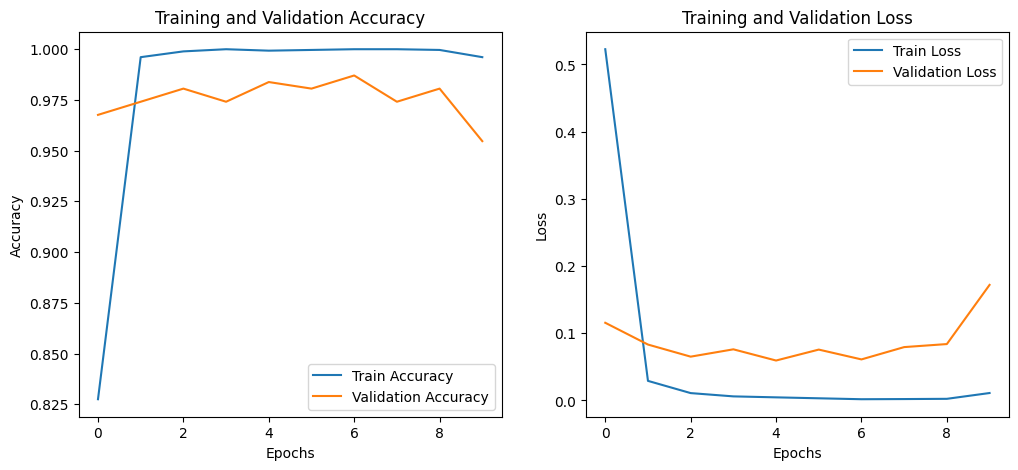

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 30s 522ms/step


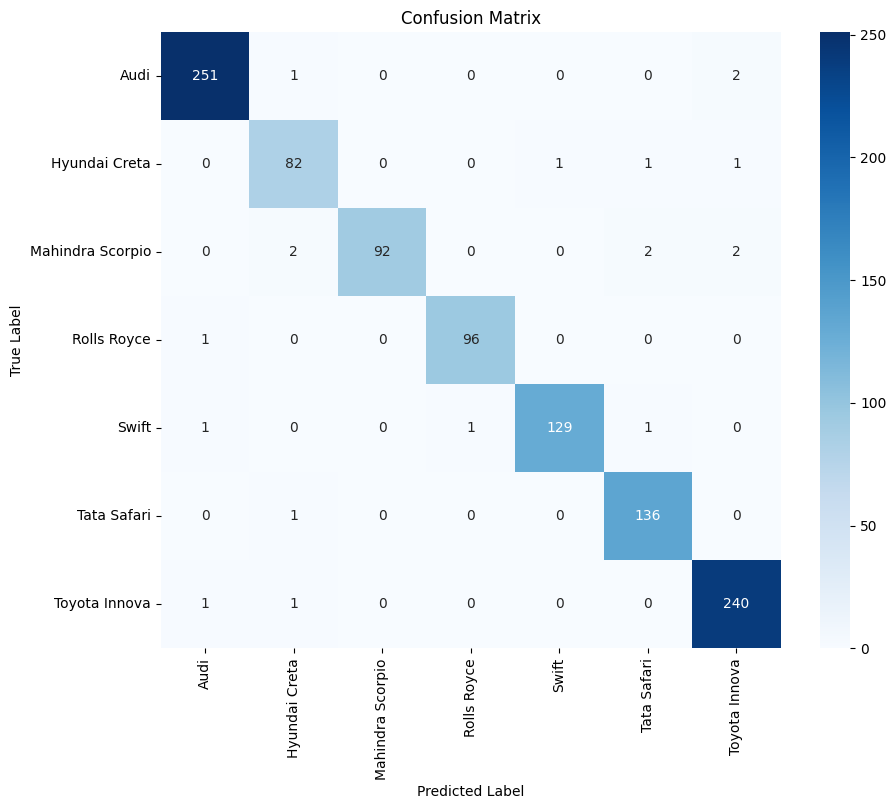

Classification Report:
                  precision    recall  f1-score   support

            Audi       0.99      0.99      0.99       254
   Hyundai Creta       0.94      0.96      0.95        85
Mahindra Scorpio       1.00      0.94      0.97        98
     Rolls Royce       0.99      0.99      0.99        97
           Swift       0.99      0.98      0.98       132
     Tata Safari       0.97      0.99      0.98       137
   Toyota Innova       0.98      0.99      0.99       242

        accuracy                           0.98      1045
       macro avg       0.98      0.98      0.98      1045
    weighted avg       0.98      0.98      0.98      1045



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')


    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

def plot_confusion_matrix(model, generator):
    y_pred = model.predict(generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = generator.classes

    conf_mat = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
                xticklabels=generator.class_indices.keys(),
                yticklabels=generator.class_indices.keys())
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    print("Classification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=list(generator.class_indices.keys())))


plot_training_history(history_TL)
plot_confusion_matrix(model_TL, test_generator)
